In [1]:
import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

2025-02-28 16:34:04.682304: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-28 16:34:04.723188: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-28 16:34:04.723887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-28 16:34:05.464840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

In [3]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

## Example: Challenger Space Shuttle Disaster <span id="challenger"/>

On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend. The data are shown below (see [1]):






In [4]:
import wget
url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv'
filename = wget.download(url)
filename

100% [..............................................................] 413 / 413

'challenger_data.csv'

Temp (F), O-Ring failure?
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


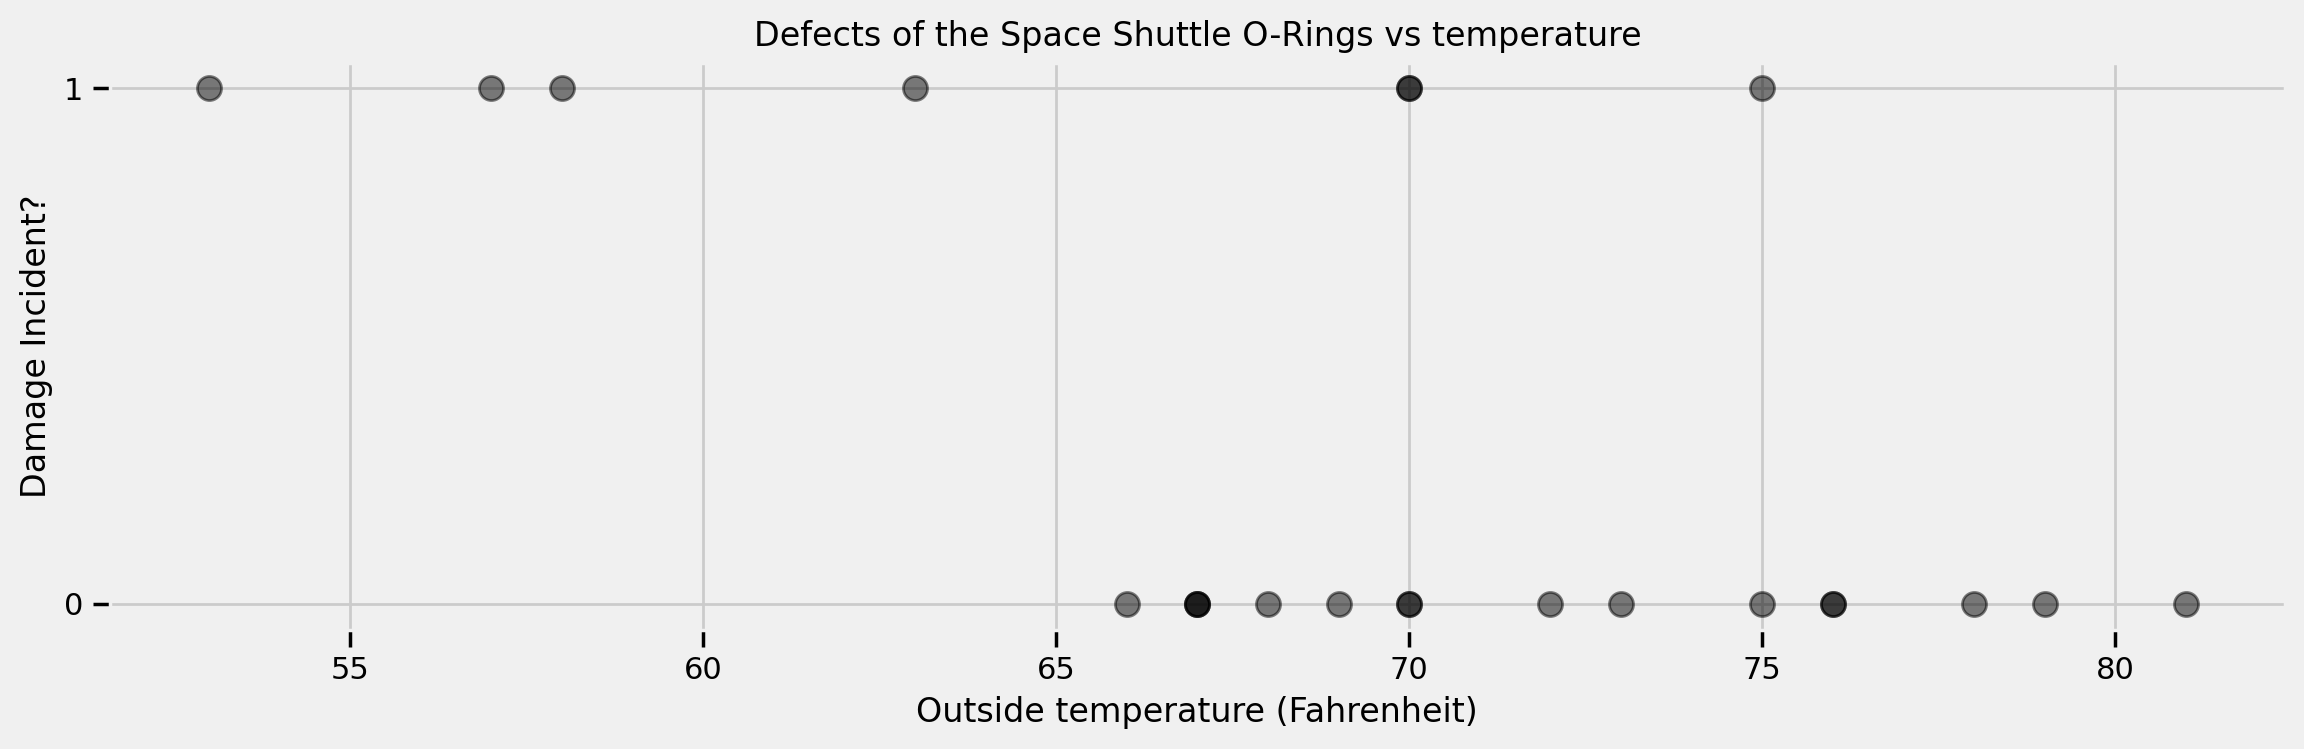

In [5]:
plt.figure(figsize(12.5, 3.5))
np.set_printoptions(precision=3, suppress=True)
challenger_data_ = np.genfromtxt("challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data_ = challenger_data_[~np.isnan(challenger_data_[:, 1])]

#plot it, as a function of tempature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data_)

plt.scatter(challenger_data_[:, 0], challenger_data_[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");


It looks clear that *the probability* of damage incidents occurring increases as the outside temperature decreases. We are interested in modeling the probability here because it does not look like there is a strict cutoff point between temperature and a damage incident occurring. The best we can do is ask "At temperature $t$, what is the probability of a damage incident?". The goal of this example is to answer that question.

We need a function of temperature, call it $p(t)$, that is bounded between 0 and 1 (so as to model a probability) and changes from 1 to 0 as we increase temperature. There are actually many such functions, but the most popular choice is the *logistic function.*

$$p(t) = \frac{1}{ 1 + e^{ \;\beta t } } $$

In this model, $\beta$ is the variable we are uncertain about. Below is the function plotted for $\beta = 1, 3, -5$.

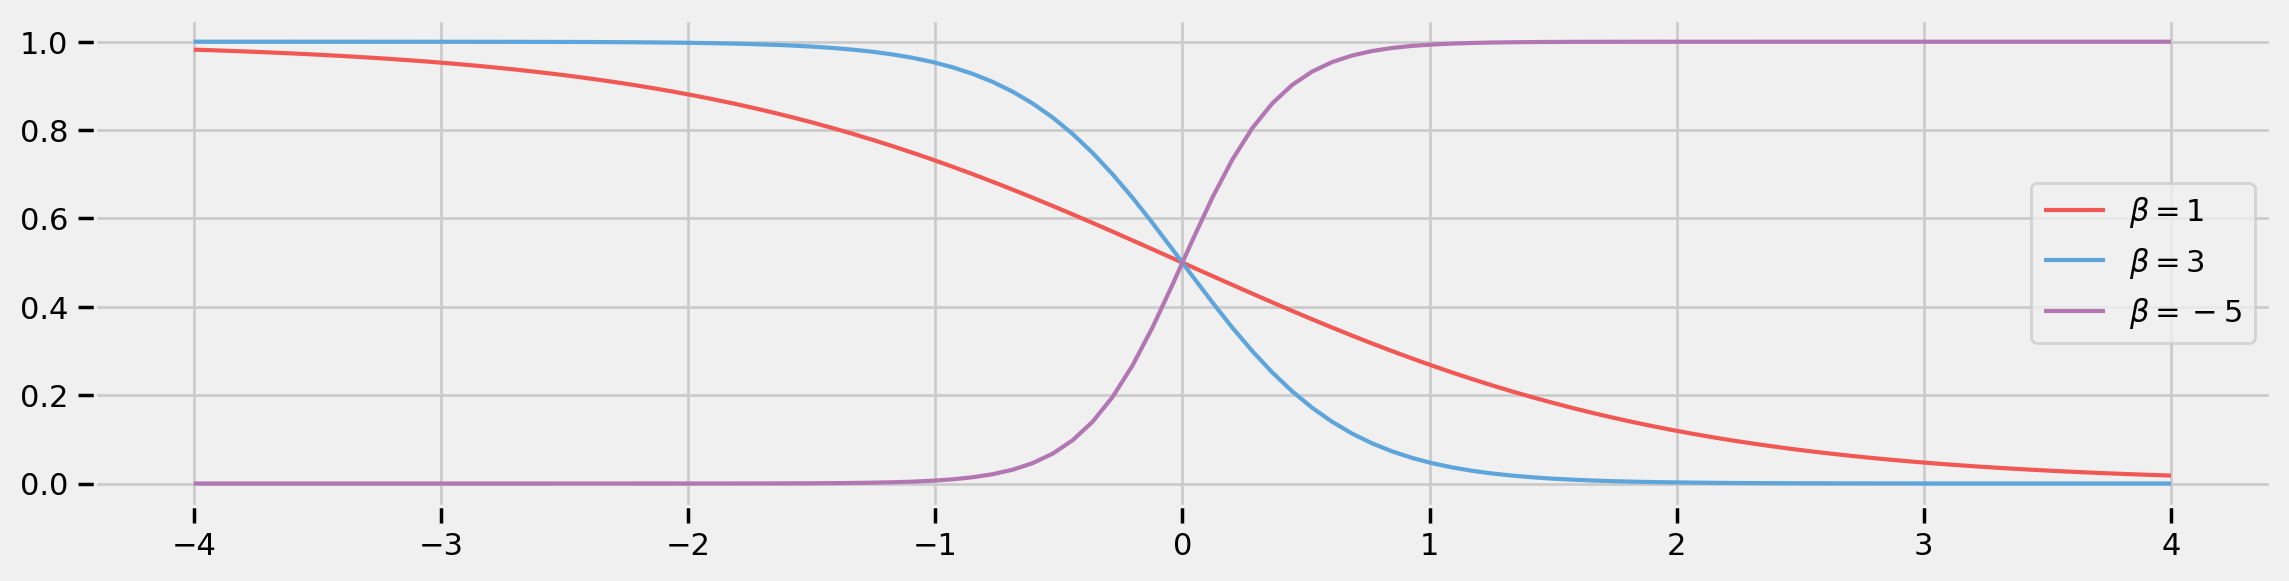

In [7]:
def logistic(x, beta):
    """
    Logistic Function
        
    Args:
      x: independent variable
      beta: beta term
    Returns: 
      Logistic function
    """
    return 1.0 / (1.0 + tf.exp(beta * x))

x_vals = tf.linspace(start=-4., stop=4., num=100)
log_beta_1 = logistic(x_vals, 1.)
log_beta_3 = logistic(x_vals, 3.)
log_beta_m5 = logistic(x_vals, -5.)


plt.figure(figsize(12.5, 3))
plt.plot(x_vals.numpy(), log_beta_1.numpy(), label=r"$\beta = 1$", color=TFColor[0])
plt.plot(x_vals.numpy(), log_beta_3.numpy(), label=r"$\beta = 3$", color=TFColor[3])
plt.plot(x_vals.numpy(), log_beta_m5.numpy(), label=r"$\beta = -5$", color=TFColor[6])
plt.legend()

But something is missing. In the plot of the logistic function, the probability changes only near zero, but in our data above the probability changes around 65 to 70. We need to add a *bias* term to our logistic function:

$$p(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$

Some plots are below, with differing $\alpha$.

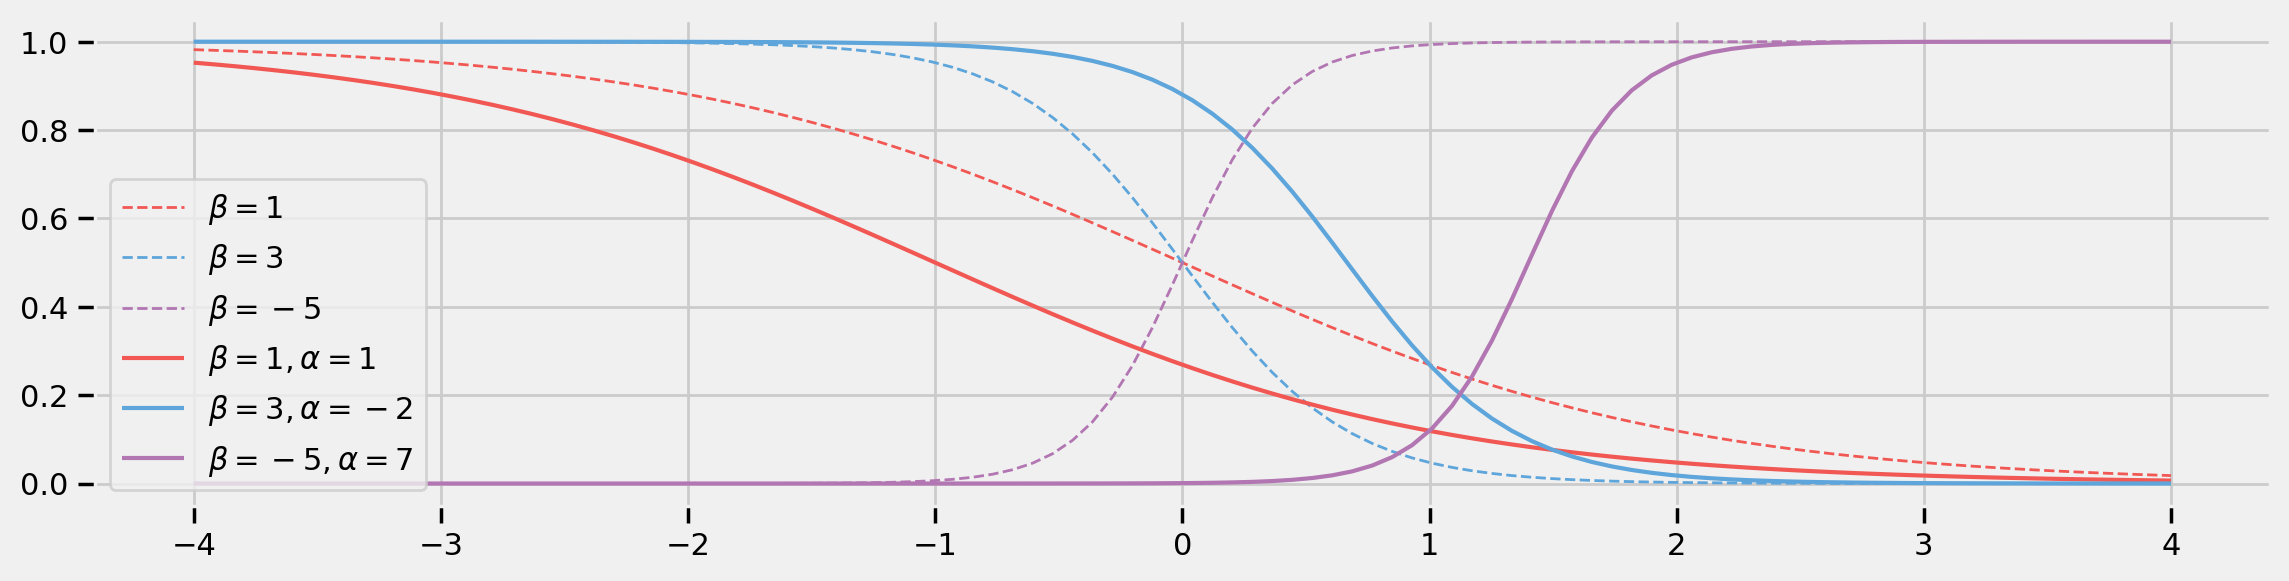

In [8]:
def logistic(x, beta, alpha=0):
    """
    Logistic Function with offset
        
    Args:
        x: independent variable
        beta: beta term 
        alpha: alpha term
    Returns: 
        Logistic function
    """
    return 1.0 / (1.0 + tf.exp((beta * x) + alpha))

x_vals = tf.linspace(start=-4., stop=4., num=100)
log_beta_1_alpha_1 = logistic(x_vals, 1, 1)
log_beta_3_alpha_m2 = logistic(x_vals, 3, -2)
log_beta_m5_alpha_7 = logistic(x_vals, -5, 7)


plt.figure(figsize(12.5, 3))
plt.plot(x_vals.numpy(), log_beta_1.numpy(), label=r"$\beta = 1$", ls="--", lw=1, color=TFColor[0])
plt.plot(x_vals.numpy(), log_beta_3.numpy(), label=r"$\beta = 3$", ls="--", lw=1, color=TFColor[3])
plt.plot(x_vals.numpy(), log_beta_m5.numpy(), label=r"$\beta = -5$", ls="--", lw=1, color=TFColor[6])
plt.plot(x_vals.numpy(), log_beta_1_alpha_1.numpy(), label=r"$\beta = 1, \alpha = 1$", color=TFColor[0])
plt.plot(x_vals.numpy(), log_beta_3_alpha_m2.numpy(), label=r"$\beta = 3, \alpha = -2$", color=TFColor[3])
plt.plot(x_vals.numpy(), log_beta_m5_alpha_7.numpy(), label=r"$\beta = -5, \alpha = 7$", color=TFColor[6])
plt.legend(loc="lower left")

Adding a constant term $\alpha$ amounts to shifting the curve left or right (hence why it is called a *bias*).

Let's start modeling this in TFP. The $\beta, \alpha$ parameters have no reason to be positive, bounded or relatively large, so they are best modeled by a *Normal random variable*, introduced next.

In [10]:

temperature_ = challenger_data_[:, 0]
temperature = tf.convert_to_tensor(temperature_, dtype=tf.float32)
D_ = challenger_data_[:, 1]                # defect or not?
D = tf.convert_to_tensor(D_, dtype=tf.float32)

We have our probabilities, but how do we connect them to our observed data? A *Bernoulli* random variable with parameter $p$, denoted $\text{Ber}(p)$, is a random variable that takes value 1 with probability $p$, and 0 else. Thus, our model can look like:

$$ \text{Defect Incident, }D_i \sim \text{Ber}( \;p(t_i)\; ), \;\; i=1..N$$

where $p(t)$ is our logistic function and $t_i$ are the temperatures we have observations about. Notice in the code below we set the values of `beta` and `alpha` to 0 in `initial_chain_state`. The reason for this is that if `beta` and `alpha` are very large, they make `p` equal to 1 or 0. Unfortunately, `tfd.Bernoulli` does not like probabilities of exactly 0 or 1, though they are mathematically well-defined probabilities. So, by setting the coefficient values to `0`, we set the variable `p` to be a reasonable starting value. This has no effect on our results, nor does it mean we are including any additional information in our prior. It is simply a computational caveat in TFP. 

$$
\text{target_log_prob} = \text{log} p(\text{data}|\alpha, \beta) + \text{log} p(\alpha) + \text{log} p(\beta)
$$

In [17]:
def challenger_joint_log_prob(D, temperature_, alpha, beta):
    """
    Joint log probability optimization function.
        
    Args:
      D: The Data from the challenger disaster representing presence or 
         absence of defect
      temperature_: The Data from the challenger disaster, specifically the temperature on 
         the days of the observation of the presence or absence of a defect
      alpha: one of the inputs of the HMC
      beta: one of the inputs of the HMC
    Returns: 
      Joint log probability optimization function.
    """
    rv_alpha = tfd.Normal(loc=0., scale=1000.)
    rv_beta = tfd.Normal(loc=0., scale=1000.)

    # make this into a logit
    logistic_p = 1.0/(1. + tf.exp(beta * tf.cast(temperature_, tf.float32) + alpha))
    rv_observed = tfd.Bernoulli(probs=logistic_p)
    
    return (
        rv_alpha.log_prob(alpha)
        + rv_beta.log_prob(beta)
        + tf.reduce_sum(rv_observed.log_prob(D))
    )

In [12]:
# wrap the mcmc sampling call in a @tf.function to speed it up
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
    return tfp.mcmc.sample_chain(*args, **kwargs)

In [18]:
number_of_steps = 10000 #@param {type:"slider", min:2500, max:120000, step:100}
burnin = 2000 #@param {type:"slider", min:2000, max:100000, step:100}

# Set the chain's start state.
initial_chain_state = [
    0. * tf.ones([], dtype=tf.float32, name="init_alpha"),
    0. * tf.ones([], dtype=tf.float32, name="init_beta")
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
# Alpha is 100x of beta approximately, so apply Affine scalar bijector
# to multiply the unconstrained alpha by 100 to get back to 
# the Challenger problem space
unconstraining_bijectors = [
    tfp.bijectors.Scale(100.),
    tfp.bijectors.Identity()
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: challenger_joint_log_prob(D, temperature_, *args)

# Initialize the step_size. (It will be automatically adapted.)
step_size = 0.01

# Defining the HMC
hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=40, #to improve convergence
        step_size=step_size,
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=hmc, num_adaptation_steps=int(burnin * 0.8)
)

# Sampling from the chain.
[
    posterior_alpha,
    posterior_beta
], kernel_results = graph_sample_chain(
    num_results = number_of_steps,
    num_burnin_steps = burnin,
    current_state=initial_chain_state,
    kernel=kernel)


/home/evanzai/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


AttributeError: module 'tensorflow' has no attribute 'global_variables_initializer'

#### Execute the TF graph to sample from the posterior

In [41]:

    
print("acceptance rate: {}".format(
        tf.reduce_mean(tf.cast(kernel_results.inner_results.inner_results.is_accepted, dtype=tf.float32))
    )
)
print("final step size: {}".format(
    tf.reduce_mean(kernel_results.inner_results.inner_results.accepted_results.step_size[-100:])))


acceptance rate: 0.45719999074935913
final step size: 0.007720481604337692


We have trained our model on the observed data, so lets look at the posterior distributions for $\alpha$ and $\beta$:

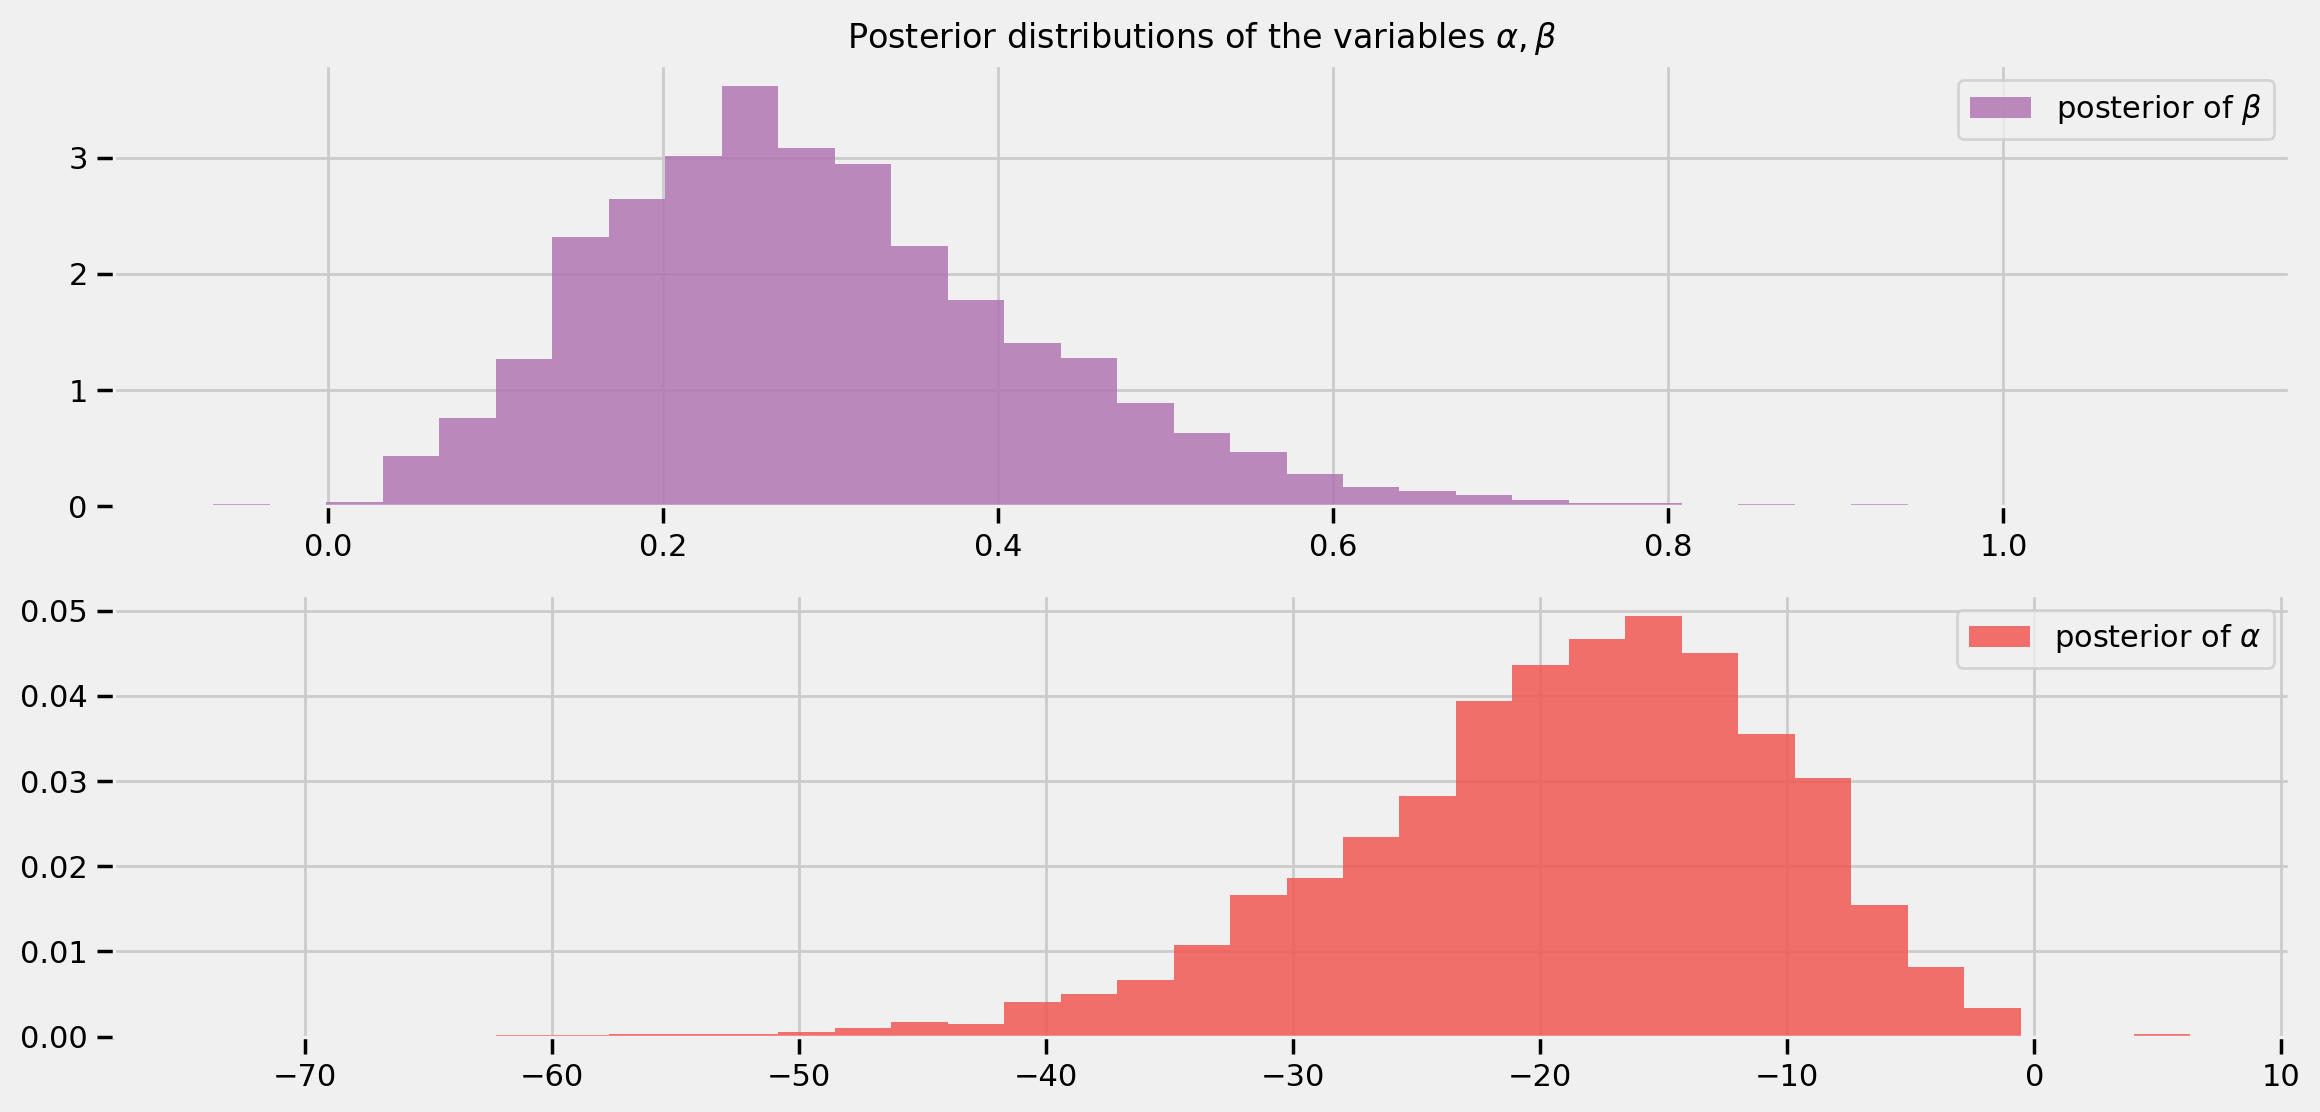

In [43]:
plt.figure(figsize(12.5, 6))

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(posterior_beta, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color=TFColor[6], density=True)
plt.legend()

plt.subplot(212)
plt.hist(posterior_alpha, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color=TFColor[0], density=True)
plt.legend();

All samples of $\beta$ are greater than 0. If instead the posterior was centered around 0, we may suspect that $\beta = 0$, implying that temperature has no effect on the probability of defect. 

Similarly, all $\alpha$ posterior values are negative and far away from 0, implying that it is correct to believe that $\alpha$ is significantly less than 0. 

Regarding the spread of the data, we are very uncertain about what the true parameters might be (though considering the low sample size and the large overlap of defects-to-nondefects this behaviour is perhaps expected).  

Next, let's look at the *expected probability* for a specific value of the temperature. That is, we average over all samples from the posterior to get a likely value for $p(t_i)$.

In [55]:
alpha_samples_1d = posterior_alpha[:, None]  # best to make them 1d
beta_samples_1d = posterior_beta[:, None]

beta_mean = tf.reduce_mean(tf.transpose(beta_samples_1d)[0])
alpha_mean = tf.reduce_mean(tf.transpose(alpha_samples_1d)[0])


print("beta mean:", beta_mean)
print("alpha mean:", alpha_mean)
def logistic(x, beta, alpha=0):
    """
    Logistic function with alpha and beta.
        
    Args:
      x: independent variable
      beta: beta term 
      alpha: alpha term
    Returns: 
      Logistic function
    """
    return 1.0 / (1.0 + tf.exp((beta * x) + alpha))

t = np.linspace(tf.reduce_min(temperature) - 5, tf.reduce_max(temperature) + 5, 2500)[:, None]
p_t = logistic(t_.T, beta_samples_1d, alpha_samples_1d)
mean_prob_t = logistic(t, beta_mean, alpha_mean)

beta mean: tf.Tensor(0.29278022, shape=(), dtype=float32)
alpha mean: tf.Tensor(-19.110872, shape=(), dtype=float32)


In [59]:
p_t.shape

TensorShape([10000, 2500])

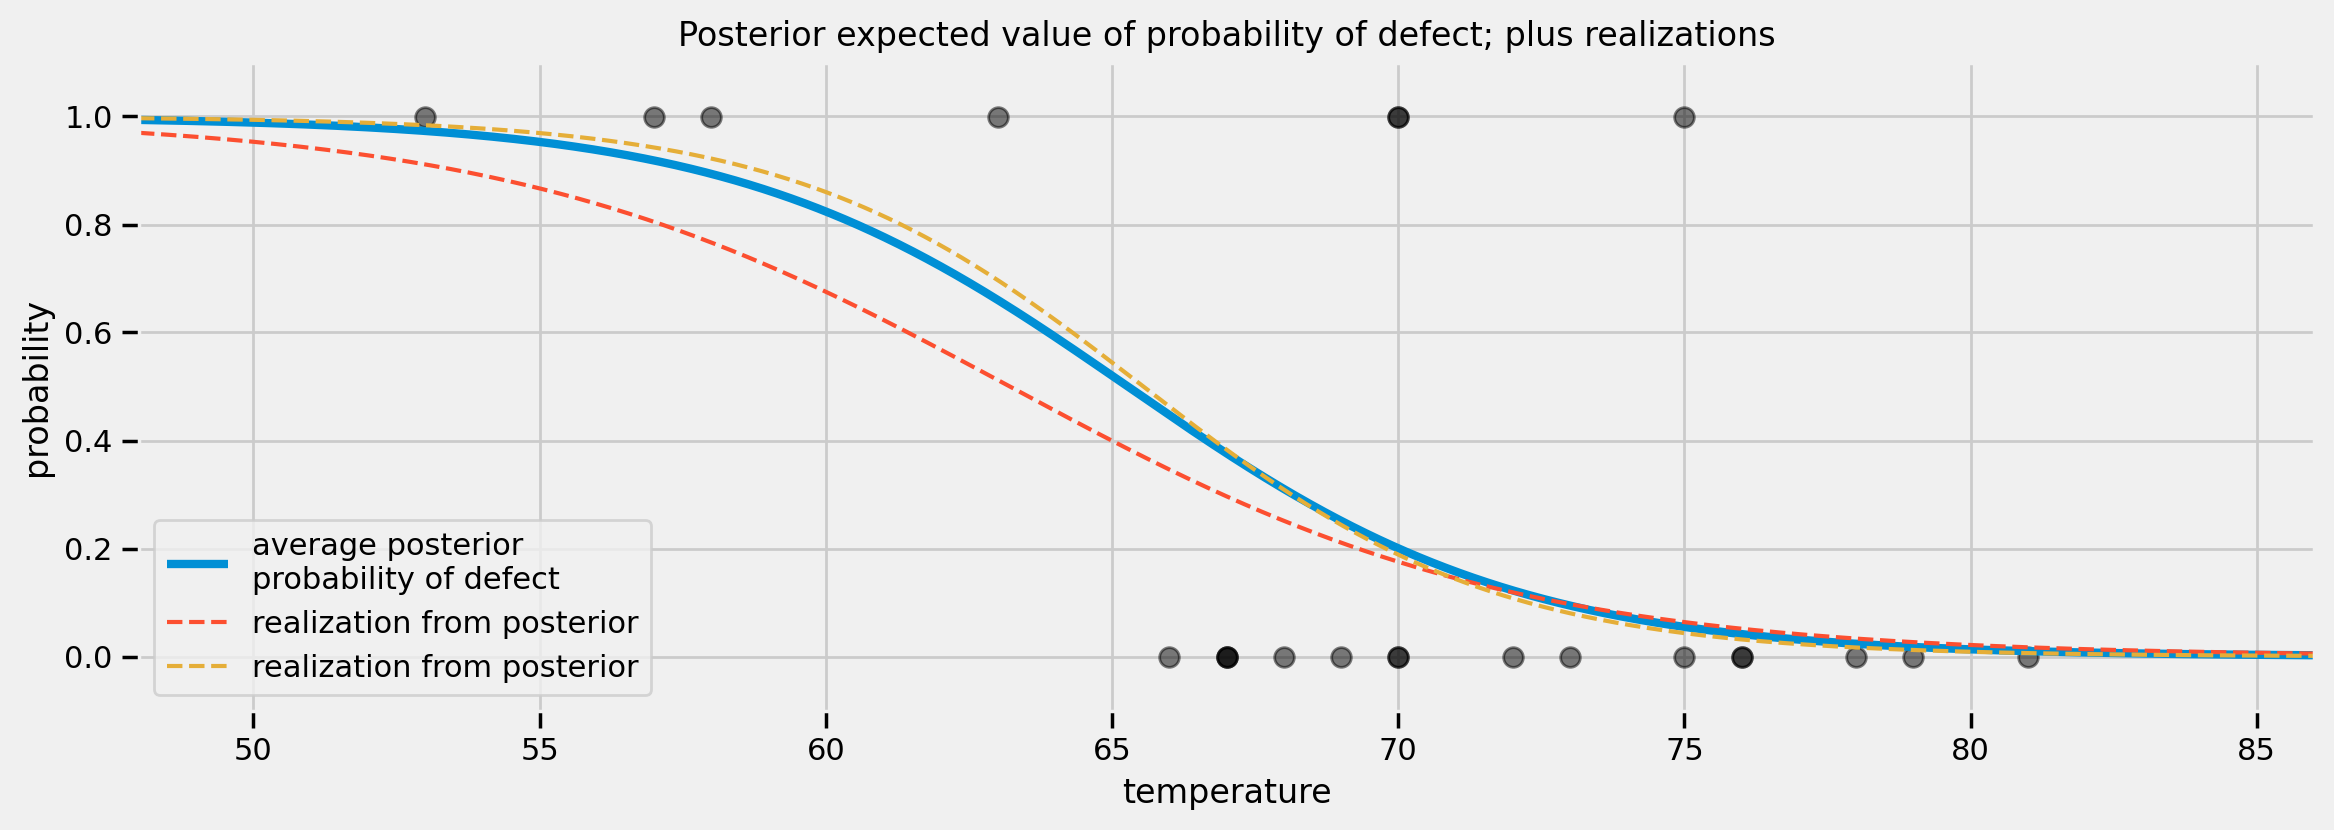

In [61]:
plt.figure(figsize(12.5, 4))

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0,:], ls="--", label="realization from posterior")
plt.plot(t, p_t[-8,:], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(tf.reduce_min(t), tf.reduce_max(t))
plt.ylabel("probability")
plt.xlabel("temperature");

Above we also plotted two possible realizations of what the actual underlying system might be. Both are equally likely as any other draw. The blue line is what occurs when we average all the 20000 possible dotted lines together.


In [63]:
t.shape

(2500, 1)

In [64]:
mean_prob_t.shape

TensorShape([2500, 1])

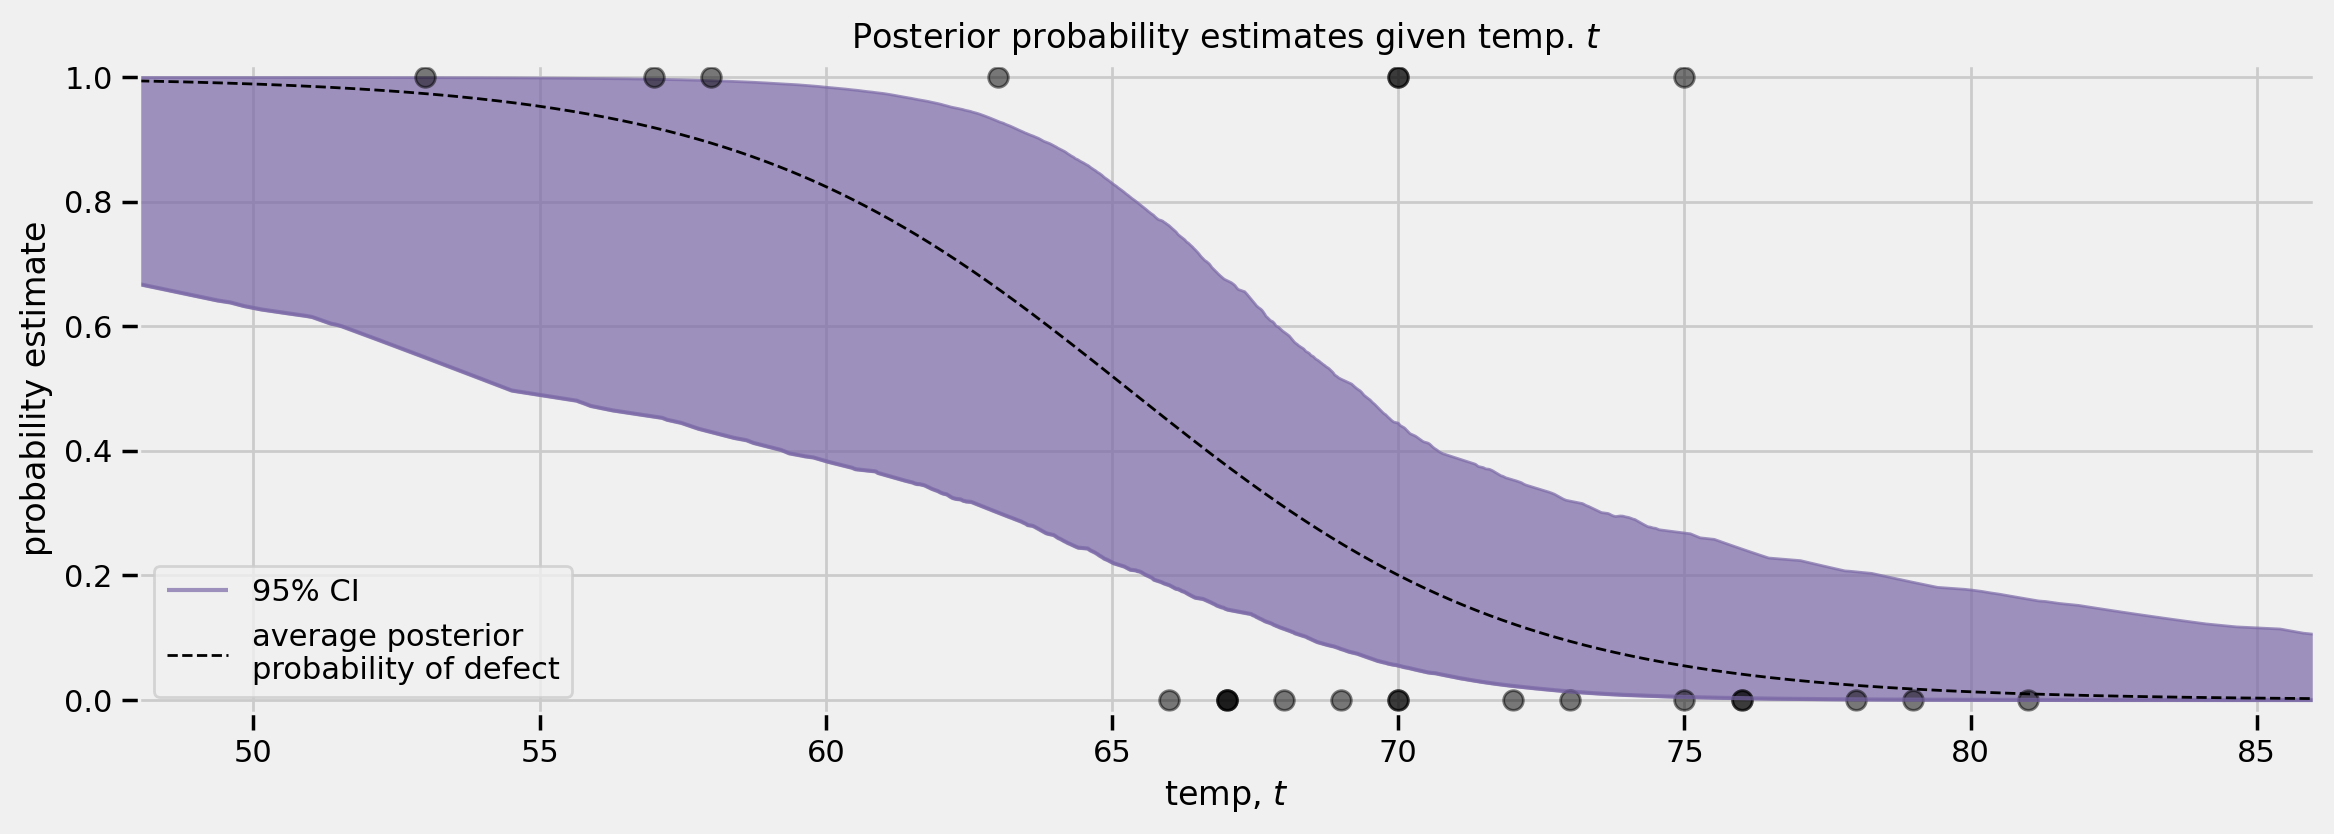

In [65]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t_[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t[:, 0], mean_prob_t[:, 0], lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(tf.reduce_min(t), tf.reduce_max(t))
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

The 95% credible interval, or 95% CI, painted in purple, represents the interval, for each temperature, that contains 95% of the distribution. For example, at 65 degrees, we can be 95% sure that the probability of defect lies between 0.25 and 0.85.

More generally, we can see that as the temperature nears 60 degrees, the CI's spread out over $[0,1]$ quickly. As we pass 70 degrees, the CI's tighten again. This can give us insight about how to proceed next: we should probably test more O-rings around 60-65 temperature to get a better estimate of probabilities in that range. Similarly, when reporting to scientists your estimates, you should be very cautious about simply telling them the expected probability, as we can see this does not reflect how *wide* the posterior distribution is.

### What about the day of the Challenger disaster?

On the day of the Challenger disaster, the outside temperature was 31 degrees Fahrenheit. What is the posterior distribution of a defect occurring,  given this temperature? The distribution is plotted below. It looks almost guaranteed that the Challenger was going to be subject to defective O-rings.

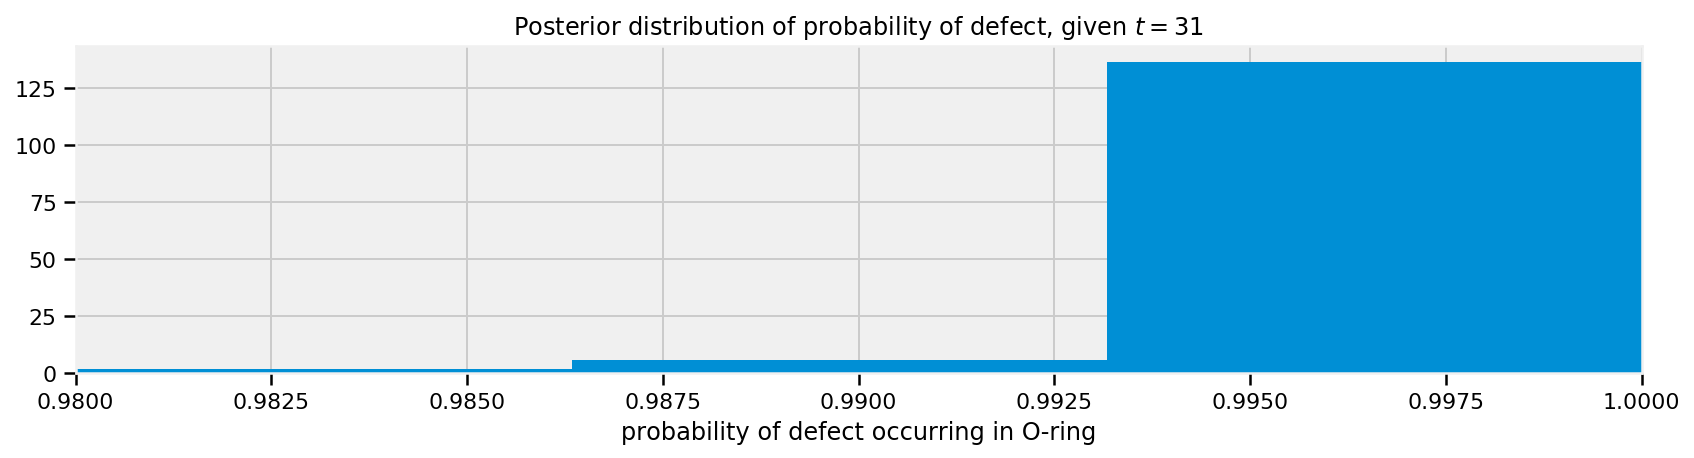

In [57]:
plt.figure(figsize(12.5, 3))

prob_31 = logistic(31, posterior_beta_, posterior_alpha_)

[ prob_31_ ] = evaluate([ prob_31 ])

plt.xlim(0.98, 1)
plt.hist(prob_31_, bins=10, density=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");

### Is our model appropriate?

The skeptical reader will say "You deliberately chose the logistic function for $p(t)$ and the specific priors. Perhaps other functions or priors will give different results. How do I know I have chosen a good model?" This is absolutely true. To consider an extreme situation, what if I had chosen the function $p(t) = 1,\; \forall t$, which guarantees a defect always occurring: I would have again predicted disaster on January 28th. Yet this is clearly a poorly chosen model. On the other hand, if I did choose the logistic function for $p(t)$, but specified all my priors to be very tight around 0, likely we would have very different posterior distributions. How do we know our model is an expression of the data? This encourages us to measure the model's **goodness of fit**.

We can think: *how can we test whether our model is a bad fit?* An idea is to compare observed data with artificial dataset which we can simulate. The rationale is that if the simulated dataset does not appear similar, statistically, to the observed dataset, then likely our model is not accurately represented the observed data. 

Previously in this Chapter, we simulated an artificial dataset for the SMS example. To do this, we sampled values from the priors. We saw how varied the resulting datasets looked like, and rarely did they mimic our observed dataset. In the current example,  we should sample from the *posterior* distributions to create *very plausible datasets*. Luckily, our Bayesian framework makes this very easy. We only need to gather samples from the distribution of choice, and specify the number of samples, the shape of the samples (we had 21 observations in our original dataset, so we'll make the shape of each sample 21), and the probability we want to use to determine the ratio of 1 observations to 0 observations.


Hence we create the following:

```python
simulated_data = tfd.Bernoulli(name="simulation_data", probs=p).sample(sample_shape=N)
```
Let's simulate 10 000:

In [ ]:
alpha = alpha_mean_ # We're basing these values on the outputs of our model above
beta = beta_mean_
p_deterministic = tfd.Deterministic(name="p", loc=1.0/(1. + tf.exp(beta * temperature_ + alpha))).sample()#seed=6.45)
simulated_data = tfd.Bernoulli(name="bernoulli_sim", 
                               probs=p_deterministic_).sample(sample_shape=10000)
[ 
    bernoulli_sim_samples_,
    p_deterministic_
] =evaluate([
    simulated_data,
    p_deterministic
])

Number of simulations:              10000
Number data points per simulation:  23


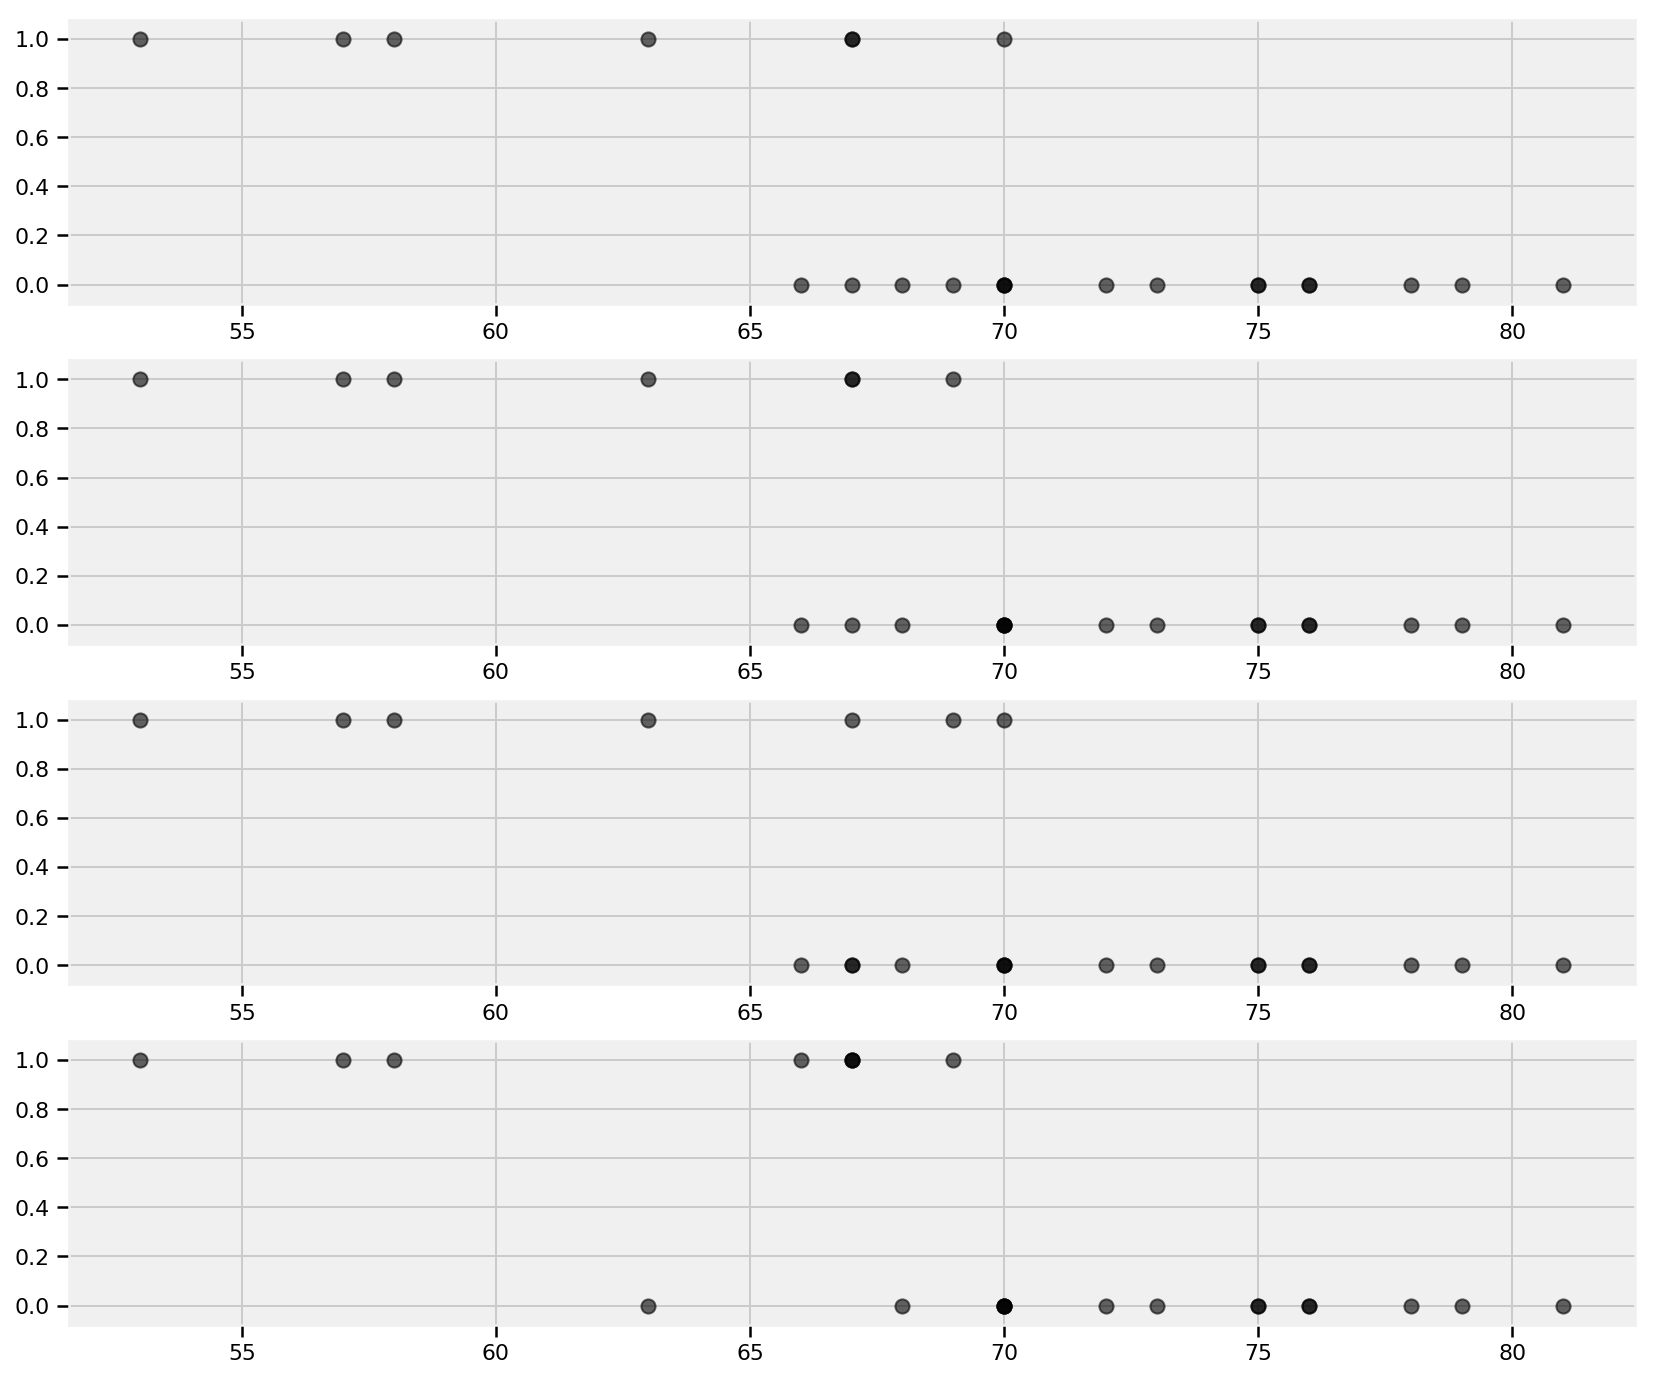

In [67]:
simulations_ = bernoulli_sim_samples_
print("Number of simulations:             ", simulations_.shape[0])
print("Number data points per simulation: ", simulations_.shape[1])

plt.figure(figsize(12.5, 12))
plt.title("Simulated dataset using posterior parameters")
for i in range(4):
    ax = plt.subplot(4, 1, i+1)
    plt.scatter(temperature_, simulations_[1000*i, :], color="k",
                s=50, alpha=0.6)
    

Note that the above plots are different (if you can think of a cleaner way to present this, please send a pull request and answer [here](http://stats.stackexchange.com/questions/53078/how-to-visualize-bayesian-goodness-of-fit-for-logistic-regression)!).

We wish to assess how good our model is. "Good" is a subjective term of course, so results must be relative to other models. 

We will be doing this graphically as well, which may seem like an even less objective method. The alternative is to use *Bayesian p-values*. These are still subjective, as the proper cutoff between good and bad is arbitrary. Gelman emphasises that the graphical tests are more illuminating [3] than p-value tests. We agree.

The following graphical test is a novel data-viz approach to logistic regression. The plots are called *separation plots*[4]. For a suite of models we wish to compare, each model is plotted on an individual separation plot. I leave most of the technical details about separation plots to the very accessible [original paper](https://onlinelibrary.wiley.com/doi/10.1111/j.1540-5907.2011.00525.x), but I'll summarize their use here.

For each model, we calculate the proportion of times the posterior simulation proposed a value of 1 for a particular temperature, i.e. compute $P( \;\text{Defect} = 1 | t, \alpha, \beta )$ by averaging. This gives us the posterior probability of a defect at each data point in our dataset. For example, for the model we used above:

In [68]:
posterior_probability_ = simulations_.mean(axis=0)
print("posterior prob of defect | realized defect ")
for i in range(len(D_)):
    print("%.2f                     |   %d" % (posterior_probability_[i], D_[i]))

posterior prob of defect | realized defect 
0.47                     |   0
0.20                     |   1
0.25                     |   0
0.31                     |   0
0.39                     |   0
0.11                     |   0
0.08                     |   0
0.19                     |   0
0.94                     |   1
0.71                     |   1
0.19                     |   1
0.02                     |   0
0.39                     |   0
0.99                     |   1
0.39                     |   0
0.05                     |   0
0.19                     |   0
0.01                     |   0
0.03                     |   0
0.01                     |   0
0.04                     |   1
0.03                     |   0
0.92                     |   1


Next we sort each column by the posterior probabilities:

In [69]:
ix_ = np.argsort(posterior_probability_)
print("probb | defect ")
for i in range(len(D_)):
    print("%.2f  |   %d" % (posterior_probability_[ix_[i]], D_[ix_[i]]))

probb | defect 
0.01  |   0
0.01  |   0
0.02  |   0
0.03  |   0
0.03  |   0
0.04  |   1
0.05  |   0
0.08  |   0
0.11  |   0
0.19  |   0
0.19  |   0
0.19  |   1
0.20  |   1
0.25  |   0
0.31  |   0
0.39  |   0
0.39  |   0
0.39  |   0
0.47  |   0
0.71  |   1
0.92  |   1
0.94  |   1
0.99  |   1


We can present the above data better in a figure: we've created a `separation_plot` function.

<Figure size 792x216 with 0 Axes>

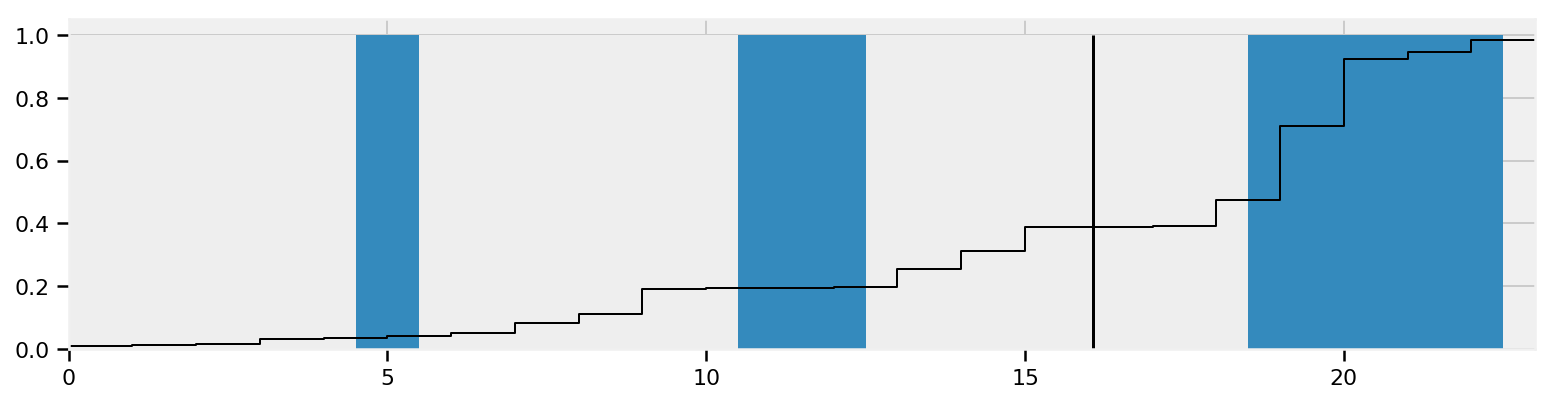

In [70]:
import matplotlib.pyplot as plt

def separation_plot( p, y, **kwargs ):
    """
    This function creates a separation plot for logistic and probit classification. 
    See https://onlinelibrary.wiley.com/doi/10.1111/j.1540-5907.2011.00525.x
    
    p: The proportions/probabilities, can be a nxM matrix which represents M models.
    y: the 0-1 response variables.
    
    """    
    assert p.shape[0] == y.shape[0], "p.shape[0] != y.shape[0]"
    n = p.shape[0]

    try:
        M = p.shape[1]
    except:
        p = p.reshape( n, 1 )
        M = p.shape[1]

    colors_bmh = np.array( ["#eeeeee", "#348ABD"] )


    fig = plt.figure( )
    
    for i in range(M):
        ax = fig.add_subplot(M, 1, i+1)
        ix = np.argsort( p[:,i] )
        #plot the different bars
        bars = ax.bar( np.arange(n), np.ones(n), width=1.,
                color = colors_bmh[ y[ix].astype(int) ], 
                edgecolor = 'none')
        ax.plot( np.arange(n+1), np.append(p[ix,i], p[ix,i][-1]), "k",
                 linewidth = 1.,drawstyle="steps-post" )
        #create expected value bar.
        ax.vlines( [(1-p[ix,i]).sum()], [0], [1] )
        plt.xlim( 0, n)
        
    plt.tight_layout()
    
    return

plt.figure(figsize(11., 3))
separation_plot(posterior_probability_, D_)

The snaking-line is the sorted probabilities, blue bars denote defects, and empty space (or grey bars for the optimistic readers) denote non-defects.  As the probability rises, we see more and more defects occur. On the right hand side, the plot suggests that as the posterior probability is large (line close to 1), then more defects are realized. This is good behaviour. Ideally, all the blue bars *should* be close to the right-hand side, and deviations from this reflect missed predictions. 

The black vertical line is the expected number of defects we should observe, given this model. This allows the user to see how the total number of events predicted by the model compares to the actual number of events in the data.

It is much more informative to compare this to separation plots for other models. Below we compare our model (top) versus three others:

1. the perfect model, which predicts the posterior probability to be equal 1 if a defect did occur.
2. a completely random model, which predicts random probabilities regardless of temperature.
3. a constant model:  where $P(D = 1 \; | \; t) = c, \;\; \forall t$. The best choice for $c$ is the observed frequency of defects, in this case 7/23.  


<Figure size 792x144 with 0 Axes>

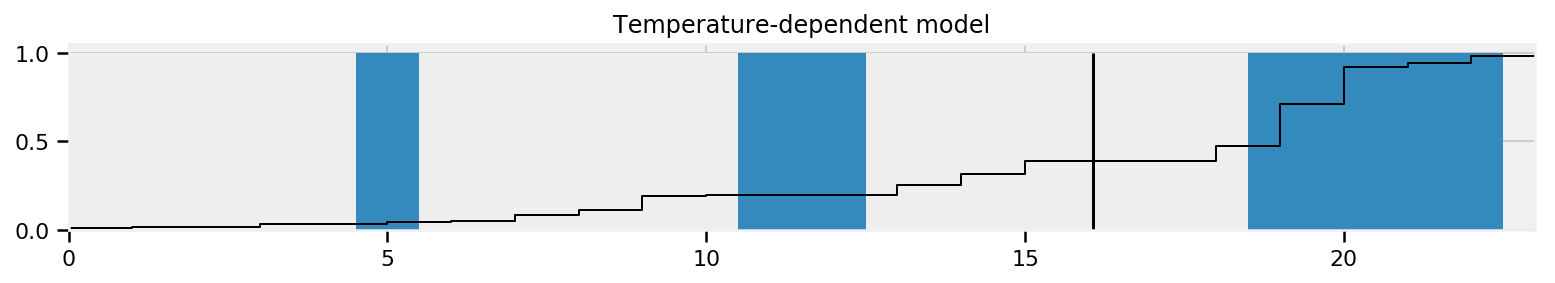

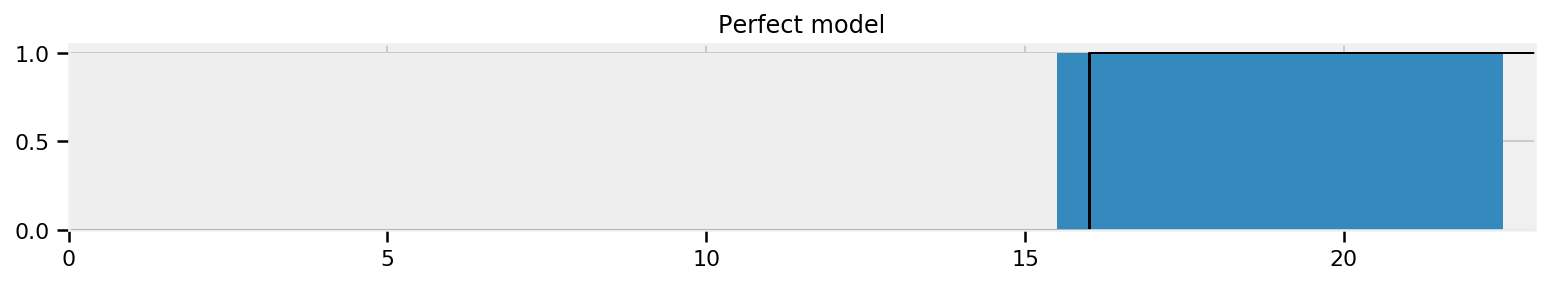

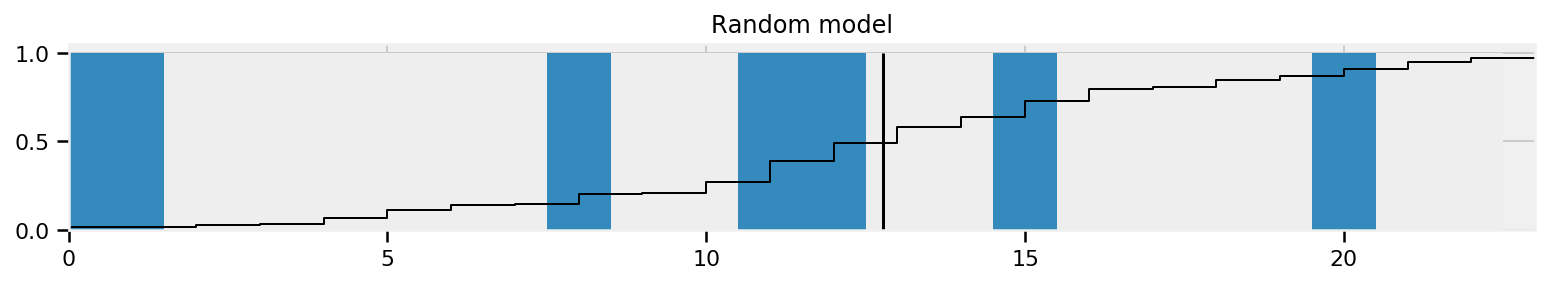

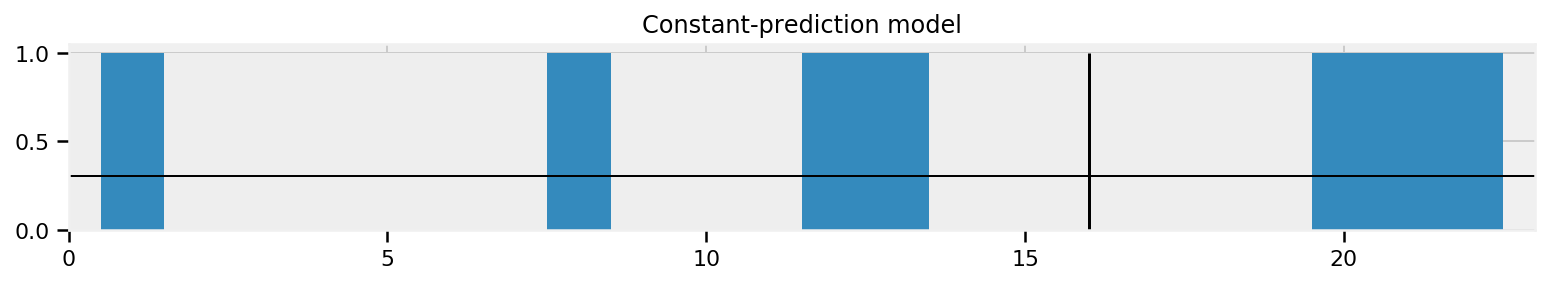

In [71]:
plt.figure(figsize(11., 2))

# Our temperature-dependent model
separation_plot(posterior_probability_, D_)
plt.title("Temperature-dependent model")

# Perfect model
# i.e. the probability of defect is equal to if a defect occurred or not.
p_ = D_
separation_plot(p_, D_)
plt.title("Perfect model")

# random predictions
p_ = np.random.rand(23)
separation_plot(p_, D_)
plt.title("Random model")

# constant model
constant_prob_ = 7./23 * np.ones(23)
separation_plot(constant_prob_, D_)
plt.title("Constant-prediction model");

In the random model, we can see that as the probability increases there is no clustering of defects to the right-hand side. Similarly for the constant model.

In the perfect model, the probability line is not well shown, as it is stuck to the bottom and top of the figure. Of course the perfect model is only for demonstration, and we cannot infer any scientific inference from it.